# Задание 5: на выбор 

Тема свободная, но нетривиальная и не пересекающаяся с заданиями 1—4.  

# Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) использует градиенты, переходящие в последний сверточный слой, 
для создания грубой карты локализации, выделяющей важные области на изображении для прогнозирования концепции.
Простыми словами, Grad-CAM представляет из себя алгоритм визуализации конволюционных нейронных сетей (Convolutional Neural Network, CNN)

Визуализация CNN на IEEE VIS 2020(другой подход) - https://virtual.ieeevis.org/paper_f-vast-1080.html
Grad-CAM на IEEE International Conference on Computer Vision (ICCV) - https://ieeexplore.ieee.org/document/8237336

### Установка библиотек

In [3]:
!pip install opencv-python matplotlib tqdm numpy

In [4]:
!pip install "torch>=0.4.1" torchvision

### Загрузка файлов

In [5]:
!git clone https://github.com/SergeyMalyshevsky/FilesForDataVisualization.git

fatal: destination path 'FilesForDataVisualization' already exists and is not an empty directory.


In [6]:
!ls FilesForDataVisualization

classes_words.txt        hw02-dag-92n.xml         mnist2500_labels.txt
dog_and_cat.png          hw03-bin-1.txt           tree-42n.xml
hw02-dag-0.graphml       hw03-bin-2.txt           tree-60n.xml
hw02-dag-1.graphml       hw03-bin-3.txt           tree-72n.xml
hw02-dag-13n-lection.xml hw03-bin-4.txt           tree-84n.xml
hw02-dag-44n.xml         mnist2500_X.txt.zip


### Создаем класс

In [7]:
from collections import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm


class GradCAM:
    def __init__(self, model, candidate_layers=None):
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []
        
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            print("Invalid name of layer: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self.find(self.fmap_pool, target_layer)
        grads = self.find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)

        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=False
        )

        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam
    
    def encode_onehot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)
    
    def backward(self, ids):
        one_hot = self.encode_onehot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    baseline = model(images).detach().gather(1, ids)

    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

### Решаем проблему с ssl сертификатом при загрузке модели

In [8]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

### Создаем дополнительные функции для загрузки изображения, обработки и пр.

In [9]:
from __future__ import print_function

import copy
import os.path as osp

import cv2
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms


def load_images(image_paths):
    images = []
    raw_images = []
    print("Original image:")
    for i, image_path in enumerate(image_paths):
        print(image_path)
        
        img = cv2.imread(image_path)
        im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(im_rgb)
        plt.show()
    
        image, raw_image = preprocess(image_path)
        images.append(image)
        raw_images.append(raw_image)
    return images, raw_images


def get_classtable(classes_words_file_path):
    classes = []
    with open(classes_words_file_path) as lines:
        for line in lines:
            line = line.strip().split(" ", 1)[1]
            line = line.split(", ", 1)[0].replace(" ", "_")
            classes.append(line)
    return classes


def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

    
def show_layer(gcam, raw_image):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    
    img = np.uint8(gcam)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)
    plt.show()


def get_grad_cam_on_different_layers(image_path, classes_words_file_path, cuda=False):
    image_paths = [image_path]
    device = torch.device("cuda" if cuda else "cpu")

    classes = get_classtable(classes_words_file_path)

    model = models.resnet152(pretrained=True)
    model.to(device)
    model.eval()

    target_layers = ["relu", "layer1", "layer2", "layer3", "layer4"]
    target_class = 209

    images, raw_images = load_images(image_paths)
    images = torch.stack(images).to(device)

    grad_cam = GradCAM(model=model)
    probs, ids = grad_cam.forward(images)
    ids = torch.LongTensor([[target_class]] * len(images)).to(device)
    grad_cam.backward(ids=ids)

    for target_layer in target_layers:
        print("Grad-CAM: {}".format(target_layer))
        print("Class:", classes[target_class])

        regions = grad_cam.generate(target_layer=target_layer)

        for j in range(len(images)):
            show_layer(gcam=regions[j, 0], raw_image=raw_images[j])

### Выводим послойно изображение с отображение активированных областей для класса Labrador retriever (порода собак)

Original image:
FilesForDataVisualization/dog_and_cat.png


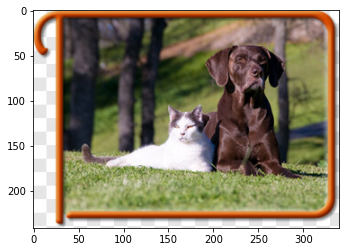

/Users/a18234587/PycharmProjects/DataVisualization/venv/lib/python3.6/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Grad-CAM: relu
Class: Chesapeake_Bay_retriever


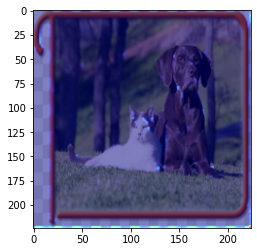

Grad-CAM: layer1
Class: Chesapeake_Bay_retriever


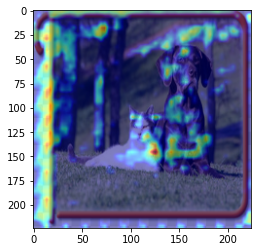

Grad-CAM: layer2
Class: Chesapeake_Bay_retriever


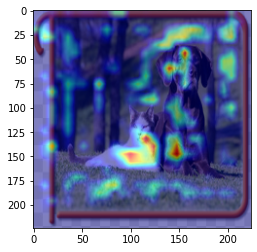

Grad-CAM: layer3
Class: Chesapeake_Bay_retriever


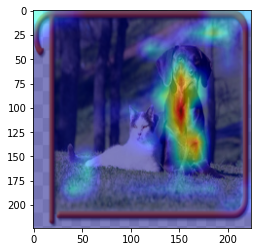

Grad-CAM: layer4
Class: Chesapeake_Bay_retriever


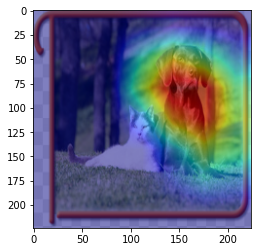

In [10]:
get_grad_cam_on_different_layers(image_path='FilesForDataVisualization/dog_and_cat.png', classes_words_file_path="FilesForDataVisualization/classes_words.txt")